In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 32*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
import pandas as pd
df = pd.read_csv("../with_diffusions_second_search/df_network_analysis_full_topology_with_alienor_mesh_and_diffusion_estimates.csv")
df["index"] = range(df.shape[0])

In [4]:
def load_dataset(path, cont=False):
    if cont:
        with open(f"../{path[:-4]}_2", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    else:
        with open(f"../{path}", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

# def load_dataset(index):
#     with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
#         params = np.load(f)
#     (n_val, 
#      b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
#      b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
#      b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
#     params = {
#               'D_A':0.01,
#               'D_B':1.0,
#               'n':n_val, 
#               'b_A':b_A_val, 
#               'mu_A':mu_A_val, 
#               'V_A':V_A_val,
#               'K_AA':K_AA_val, 
#               'K_AB':K_AB_val,  
#               'K_AC':K_AC_val,
#               'b_B':b_B_val, 
#               'mu_B':mu_B_val, 
#               'V_B':V_B_val,
#               'K_BA':K_BA_val, 
#               'K_BC':K_BC_val,  
#               'b_C':b_C_val, 
#               'mu_C':mu_C_val, 
#               'V_C':V_C_val,
#               'K_CB':K_CB_val, 
#               'K_CC':K_CC_val
#              }
        
#     with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
#         res_128_50 = np.load(f)
#     with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
#         res_128_10= np.load(f)
#     with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
#         res_128_1 = np.load(f)
#     return (params, res_128_50, res_128_10, res_128_1)

10 outputs_second_search/solution_10_10_103.npy
index                                                              10
type                                                             spot
estimated_params    (0.9998756872706421, 6.797751713112303, 10.097...
original_params                         (1.0, 100.0, 10.0, 5.0, 10.0)
euclidian_dist                                              93.329735
search_alg                                                   L_BFGS_B
Has_closer_est                                                   True
Name: 10, dtype: object
bad_estimates                          2
list_of_bad_estimates    ('V_C', 'K_CC')
Name: 10, dtype: object
bad_estimates_A_alienor_mesh                                  2
list_of_bad_estimates_A_alienor_mesh             ('D_A', 'b_A')
bad_estimates_B_alienor_mesh                                  3
list_of_bad_estimates_B_alienor_mesh     ('b_B', 'V_B', 'K_CB')
bad_estimates_C_alienor_mesh                                  3
list_of_bad_

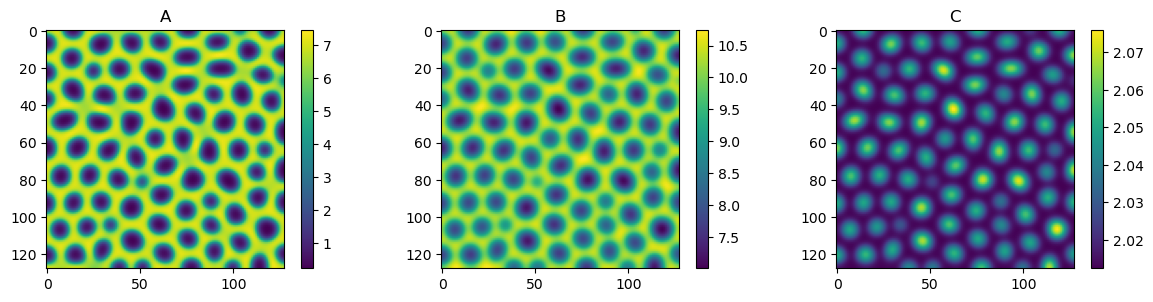

In [5]:
index = 10#2

print(index, df.iloc[index]["path"])
print(df.iloc[index][df.columns[40:47]])
print(df.iloc[index][df.columns[63:65]])
print(df.iloc[index][df.columns[-6:]])
params, res, k_max = load_dataset(df.iloc[index]["path"])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=10


data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]

##########################################
# Create a mesh that is the centers of the
# original mesh
x_size -= 1
y_size -= 1

dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]
# x_slice = slice(45, 100, 1)
# y_slice = slice(45, 100, 1)


x_slice = slice(0, x_size, 1)
y_slice = slice(0, y_size, 1)


x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)

########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


data2 = np.stack([[ (ndimage.convolve(data[i, :,:, j], kernel)/4)[:-1, :-1] 
                        for j in  range(data.shape[3])]
                        for i in  range(data.shape[0])])
data2 = np.einsum("ctxy -> cxyt", data2)
maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

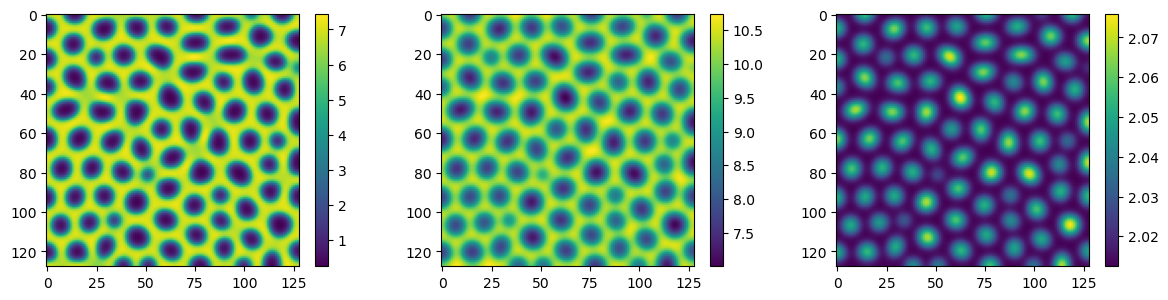

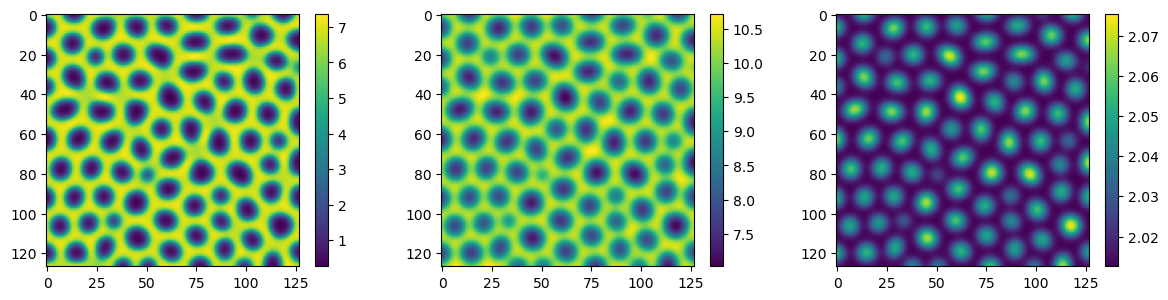

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data2[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()


# plt.figure(figsize=(12, 3))
# for i in range(3):
#     plt.subplot(1,3, i+1)
#     plt.imshow(data2[i, x_slice, y_slice, -1])
#     plt.colorbar()
# plt.tight_layout();plt.show()

In [8]:
print(np.min(data2[0, x_slice, y_slice, -1]), np.max(data2[0, x_slice, y_slice, -1]))
print(np.min(data2[1, x_slice, y_slice, -1]), np.max(data2[1, x_slice, y_slice, -1]))
print(np.min(data2[2, x_slice, y_slice, -1]), np.max(data2[2, x_slice, y_slice, -1]))

0.26591914605148625 7.366026554450499
7.0233895814372325 10.71873854854264
2.0126195375794937 2.075369089463946


In [9]:
127*127

16129

In [10]:
H.shape

TensorShape([1, 127, 127, 3])

In [11]:
data2.shape

(3, 127, 127, 1)

In [12]:
c = data2[:, x_slice, y_slice, :].copy()
def creat_for_node(node):
    def gen_series():        
        for i in range(H.shape[0]):        
            yield H[i, ...], c[node, ..., i] 
    return gen_series
        
ds_A = tf.data.Dataset.from_generator(creat_for_node(0),
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2])))
ds_B = tf.data.Dataset.from_generator(creat_for_node(1),
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2])))
ds_C = tf.data.Dataset.from_generator(creat_for_node(2),
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2])))

In [13]:
c.shape

(3, 127, 127, 1)

In [17]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    

class NN_2_res(tu.NN_base):
    def __init__(self, layers, lb, ub, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)
        self.lb = lb
        self.ub = ub
        self.build()

    def create_1_unit_layer(self, layers):
        weights = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[layers[i], layers[i + 1]])
            b = tf.Variable(tf.zeros([1, layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)
        return weights, biases 
    def build(self):
        """Create the state of the layers (weights)"""
        print(self.layers[:-1] + [3])
        print(self.layers)
        self.Ws1, self.bs1 = self.create_1_unit_layer(self.layers[:-1] + [3])
        self.Ws2, self.bs2 = self.create_1_unit_layer(self.layers)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.dtype), dtype=self.dtype
        )

    def net_1_layer(self, Ws, bs, H):
        for W, b in zip(Ws[:-1], bs[:-1]):
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
        W = Ws[-1]
        b = bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H1 = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        H1 = self.net_1_layer(self.Ws1, self.bs1, H1)
        H2 = self.net_1_layer(self.Ws2, self.bs2, tf.nn.tanh(H1))
        
        return H1 + H2

    def __call__(self, inputs):
        """Defines the computation from inputs to outputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """
        X = tf.cast(inputs, self.dtype)
        return self.net(X)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """
        partials = [tape.gradient(outputs[i], inputs) for i in range(len(outputs))]
        return partials

def create_pinn(layers=[3, 512, 512, 1],
                learning_rate=1e-2): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)    
    #pinn = tu.NN(layers, lb, ub, tf.float32)
    pinn = NN_2_res(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    #optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate)
        

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
                
        
        with tf.GradientTape(persistent=False) as tape: 
            H = elements[0]
            # remove the boundaries
            #H = H[:, 1:-1, 1:-1, :]             
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables 
            print(H.shape)

            outputs = pinn.net(H)
            Nodeg = tf.squeeze(outputs)
            print(Nodeg.shape)
            H2 = elements[1]
            # remove the boundaries
            #H2 = H2[:, 1:-1, 1:-1, :]    
            Node = tf.reshape(H2, (H2.shape[0]*H2.shape[1]*H2.shape[2],))                                   
            
            l2 = tf.reduce_mean((Node - Nodeg)**2)
        
        grads = tape.gradient(l2, trainables)
        #print(tf.reduce_mean([tf.reduce_mean(g) for g in grads]))
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2)
    
    names = ['l2']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, loss: {np.sum(losses)}")
        #printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        #printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse, names, print_callback)

In [18]:
(pinnA, optimizerA, train_step_inverseA,names, print_callbackA
) = create_pinn(layers=[3, 1024, 1024, 1],learning_rate=1e-2)
(pinnB, optimizerB, train_step_inverseB,names, print_callbackB
) = create_pinn(layers=[3, 1024, 1024, 1],learning_rate=1e-2)
(pinnC, optimizerC, train_step_inverseC,names, print_callbackC
) = create_pinn(layers=[3, 1024, 1024, 1],learning_rate=1e-2)

[3, 1024, 1024, 3]
ListWrapper([3, 1024, 1024, 1])
[3, 1024, 1024, 3]
ListWrapper([3, 1024, 1024, 1])
[3, 1024, 1024, 3]
ListWrapper([3, 1024, 1024, 1])


In [19]:
#pinn1 = tu.NN_Scaled.restore(".","temp_pinn")

In [128]:
epochs=30000+1
#params_est = np.zeros((epochs, 9))

# def epoch_callback1(epoch, loss_samples, index):
#     params_est[epoch, : ] = (b_A.numpy(), b_B.numpy(), b_C.numpy(), 
#                              V_A.numpy(), V_B.numpy(), V_C.numpy(),
#                              mu_A.numpy(), mu_B.numpy(), mu_C.numpy()
#                             )

In [184]:
pinnA.Ws2[-1].shape

TensorShape([1024, 1])

In [129]:
epochs

30001

In [130]:
H.shape[1]*H.shape[2], (H.shape[1]*H.shape[2]//2)*2, H.shape[1]*H.shape[2]//2

(16129, 16128, 8064)

In [20]:
losses1A = tu.train(epochs=1,
                  batch_size=H.shape[1]*H.shape[2],#8065,#H.shape[1]*H.shape[2]//2,
                  dataset = ds_A.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverseA,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callbackA,
                  epoch_callback=None,
                  stop_condition=None)



Start of epoch 0
(16129, 3)
(16129, 3)


ValueError: in user code:

    File "/tmp/ipykernel_25358/4260967959.py", line 166, in train_step_inverse  *
        l2 = tf.reduce_mean((Node - Nodeg)**2)

    ValueError: Dimensions must be equal, but are 16129 and 3 for '{{node sub}} = Sub[T=DT_FLOAT](Reshape_1, Squeeze)' with input shapes: [16129], [16129,3].


In [187]:
losses1A = tu.train(epochs=5000,
                  batch_size=H.shape[1]*H.shape[2],#8065,#H.shape[1]*H.shape[2]//2,
                  dataset = ds_A.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverseA,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callbackA,
                  epoch_callback=None,
                  stop_condition=None)
optimizerA.lr.assign(1e-3)
losses2A = tu.train(epochs=5000,
                  batch_size=H.shape[1]*H.shape[2],#8065,#H.shape[1]*H.shape[2]//2,
                  dataset = ds_A.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverseA,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callbackA,
                  epoch_callback=None,
                  stop_condition=None)
optimizerA.lr.assign(1e-4)
losses3A = tu.train(epochs=5000,
                  batch_size=H.shape[1]*H.shape[2],#8065,#H.shape[1]*H.shape[2]//2,
                  dataset = ds_A.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverseA,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callbackA,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
(16129,)
(16129,)
at epoch 0, loss: 80.71108818054199
Time taken: 1.30s


KeyboardInterrupt: 

In [23]:
H.shape[1],H.shape[2], H.shape[1]*H.shape[2], H.shape[1]*H.shape[2]/3

(126, 126, 15876, 5292.0)

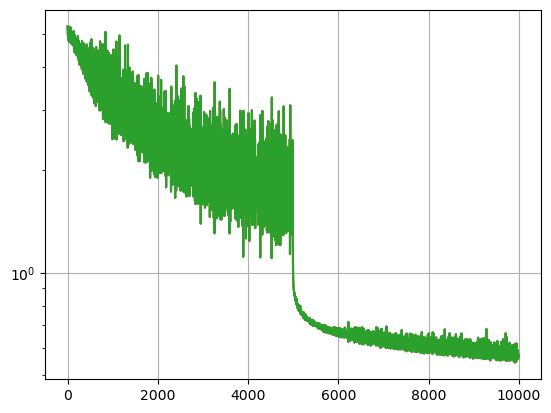

In [159]:
plt.plot(np.r_[losses2A[10:], losses3A])
plt.yscale('log');plt.grid();plt.show()

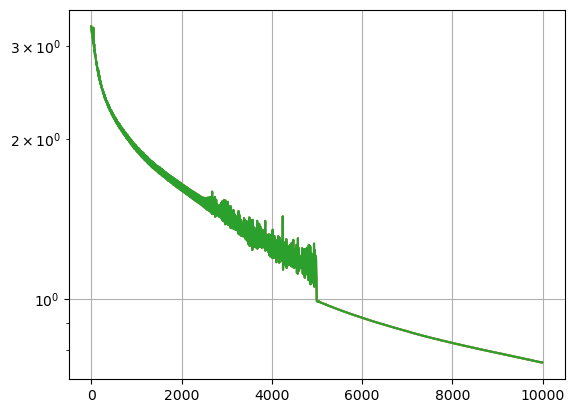

In [147]:
plt.plot(np.r_[losses2A[10:], losses3A])
plt.yscale('log');plt.grid();plt.show()

In [112]:
losses3 = tu.train(epochs=epochs,
                  batch_size=H.shape[1]*H.shape[2]//5,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-3,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 0.005430353514384478
l2_res_A: 0.00361877, l2_res_B: 0.00150507, l2_res_C: 0.00030651
Time taken: 0.12s

Start of epoch 1000
at epoch 1000, total loss: 0.005723495050915517
l2_res_A: 0.00327093, l2_res_B: 0.00221917, l2_res_C: 0.00023340
Time taken: 28.96s

Start of epoch 2000
at epoch 2000, total loss: 0.005474758130731061
l2_res_A: 0.00418479, l2_res_B: 0.00082020, l2_res_C: 0.00046977
Time taken: 28.17s

Start of epoch 3000
at epoch 3000, total loss: 0.005127102311234921
l2_res_A: 0.00316398, l2_res_B: 0.00144660, l2_res_C: 0.00051653
Time taken: 28.41s

Start of epoch 4000
at epoch 4000, total loss: 0.004980395315214992
l2_res_A: 0.00306954, l2_res_B: 0.00136341, l2_res_C: 0.00054745
Time taken: 31.83s

Start of epoch 5000
at epoch 5000, total loss: 0.00540412066038698
l2_res_A: 0.00315497, l2_res_B: 0.00186382, l2_res_C: 0.00038533
Time taken: 31.97s

Start of epoch 6000
at epoch 6000, total loss: 0.0053705983445979655
l2_res_A: 0.00317457

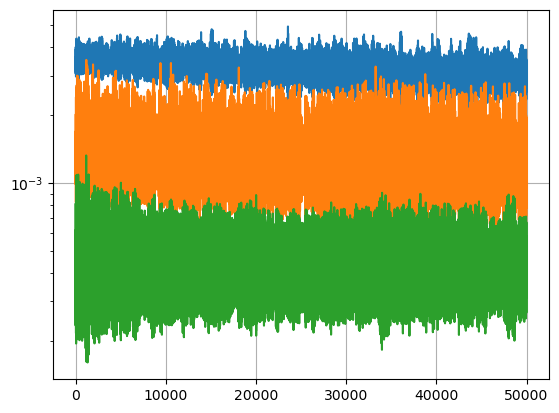

In [113]:
plt.plot(np.r_[losses3])
plt.yscale('log');plt.grid();plt.show()

In [ ]:
#Start of epoch 40000
#at epoch 40000, total loss: 0.09473658924798656
#l2_res_A: 0.07312288, l2_res_B: 0.02160452, l2_res_C: 0.00000919
#Time taken: 44.64s

In [191]:
x_range_test = L * np.linspace(0, 1, x_size+1)#[x_slice]
y_range_test = L * np.linspace(0, 1, y_size+1)#[y_slice]
X_test, Y_test = np.meshgrid(x_range_test, y_range_test)
ts_test = np.array(t_star, dtype=np.float32)
T_test = ts_test[np.newaxis, np.newaxis, :] * np.ones(X_test.shape)[:, :, np.newaxis]
H_test = H_cube(X_test, Y_test, T_test)
H_test = H_test.numpy().astype(np.float32)

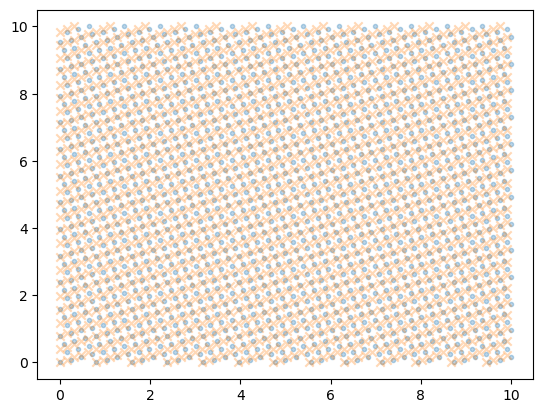

In [192]:
plt.scatter(X.numpy().flatten()[::10], Y.numpy().flatten()[::10], marker='.', alpha=.3)
plt.scatter(X_test.flatten()[::10], Y_test.flatten()[::10], marker='x', alpha=.3)

In [193]:
H_test_reshape = H_test.reshape((H_test.shape[0]*H_test.shape[1]*H_test.shape[2], H_test.shape[3]))
A_test = pinnA.net(H_test_reshape)

In [194]:
A_test.shape, H_test_reshape.shape

(TensorShape([16384, 3]), (16384, 3))

In [164]:
A_test = A_test.numpy().reshape(X_test.shape)
# B_test = test_res[:,1].numpy().reshape(X_test.shape)
# C_test = test_res[:,2].numpy().reshape(X_test.shape)
def rmse(arr1, arr2):
        return np.sqrt(np.mean((arr1-arr2)**2))
    
rmse1 = rmse(A_test[x_slice, y_slice], c[0,:, : , -1])
# rmse2 = rmse(B_test[x_slice, y_slice], c[1,:, : , -1])
# rmse3 = rmse(C_test[x_slice, y_slice], c[2,:, : , -1])

plot_n_im([A_test],#, B_test, C_test], 
          [f"test A rmse:{rmse1:.5f}"],#, f"test B rmse:{rmse2:.5f}", f"test C rmse:{rmse3:.5f}"],
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


ValueError: cannot reshape array of size 49152 into shape (128,128)

In [57]:
pinn1.save(".","temp_pinn")

In [108]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [109]:
x_size, block_x, x_slice, data.shape

(127, 55, slice(45, 100, 1), (3, 128, 128, 1))

In [110]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg)
           )                               



def plot_state(pinn, H,block_x=block_x, block_y=block_y):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    A = to(A)
    B = to(B)
    C = to(C)
    A_xx = to(A_xx)
    A_yy = to(A_yy)
    B_xx = to(B_xx)
    B_yy = to(B_yy)
    
    A_der = A_xx + A_yy
    B_der = B_xx + B_yy
    
    data_out = np.stack([A, B, C])[..., np.newaxis]
    
    c_xx_out =  np.array([[second_order_derivatives((block_x, block_y), data_out[c, ..., t])[0]/dxdy 
                        for t in range(data_out.shape[3])]
                        for c in range(data_out.shape[0])
                       ])
    c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
    c_yy_out = np.array([[second_order_derivatives((block_x, block_y), data_out[c, ..., t])[1]/dxdy 
                        for t in range(data_out.shape[3])]
                        for c in range(data_out.shape[0])
                       ])
    c_yy_out = np.einsum("ctij -> cijt", c_yy_out)
    
    A_diff_der = ( c_xx_out[0,x_slice, y_slice  , -1] + c_yy_out[0,x_slice, y_slice  , -1])
    B_diff_der = ( c_xx_out[1,x_slice, y_slice  , -1] + c_yy_out[1,x_slice, y_slice  , -1])


    actual_A_der = ( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = ( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der
    def rmse(arr1, arr2):
        return np.sqrt(np.mean((arr1-arr2)**2))
    
    rmse1 = rmse(A[x_slice, y_slice], c[0,:, : , -1])
    rmse2 = rmse(B[x_slice, y_slice], c[1,:, : , -1])
    plot_n_im([A, c[0,:, : , -1], B, c[1,:, :  , -1]], 
      [f"A rmse:{rmse1:.5f}", "Actual A", f"B rmse:{rmse2:.5f}", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()
    
    rmse3 = rmse(C[x_slice, y_slice], c[2,:, : , -1])
    plot_n_im([C[x_slice, y_slice], c[2,:, : , -1]], 
      [f"C rmse:{rmse3:.5f}", "Actual C"],          
      figsize=(6, 3)); plt.tight_layout()

#     A = c[0,:, : , -1]
#     B = c[1,:, : , -1]
#     print(np.sum((A_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
#     print(np.sum((B_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))
#     print()
#     print(np.sum((A_diff_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
#     print(np.sum((B_diff_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))
    

    rmse1 = rmse(A_xx[x_slice, y_slice], c_xx[0,x_slice, y_slice , -1])
    rmse2 = rmse(A_yy[x_slice, y_slice], c_yy[0,x_slice, y_slice  , -1])
    plot_n_im([A_xx[1:-1,1:-1], c_xx[0,x_slice, y_slice , -1],
               A_yy[1:-1,1:-1], c_yy[0,x_slice, y_slice  , -1]], 
      [f"A_xx rmse:{rmse1:.5f}", "Actual A_xx", f"A_yy rmse:{rmse2:.5f}", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()
    
    
    rmse1 = rmse(B_xx[x_slice, y_slice], c_xx[1,x_slice, y_slice , -1])
    rmse2 = rmse(B_yy[x_slice, y_slice], c_yy[1,x_slice, y_slice  , -1])
    plot_n_im([B_xx[1:-1,1:-1], c_xx[1,x_slice, y_slice  , -1], 
               B_yy[1:-1,1:-1], c_yy[1,x_slice, y_slice  , -1]],
              [f"B_xx rmse:{rmse1:.5f}", "Actual B_xx", f"B_yy rmse:{rmse2:.5f}", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
    
    rmse1 = rmse(A_der[x_slice, y_slice],  actual_A_der)
    rmse2 = rmse(B_der[x_slice, y_slice],  actual_B_der)
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              [f"RHS A rmse:{rmse1:.5f}", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              [f"RHS B rmse:{rmse2:.5f}", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()   

    rmse1 = rmse(c_xx_out[0,x_slice, y_slice , -1], c_xx[0,x_slice, y_slice , -1])
    rmse2 = rmse(c_yy_out[0,x_slice, y_slice  , -1], c_yy[0,x_slice, y_slice  , -1])
    plot_n_im([c_xx_out[0,x_slice, y_slice , -1], c_xx[0,x_slice, y_slice , -1],
               c_yy_out[0,x_slice, y_slice  , -1], c_yy[0,x_slice, y_slice  , -1]], 
              [f"A_xx diff rmse:{rmse1:.5f}", "Actual A_xx", f"A_yy diff rmse:{rmse2:.5f}", "Actual A_yy"],          
              figsize=(12, 3)); plt.tight_layout()

    rmse1 = rmse(c_xx_out[1,x_slice, y_slice  , -1], c_xx[1,x_slice, y_slice  , -1])
    rmse2 = rmse(c_yy_out[1,x_slice, y_slice  , -1], c_yy[1,x_slice, y_slice  , -1])
    plot_n_im([c_xx_out[1,x_slice, y_slice  , -1], c_xx[1,x_slice, y_slice  , -1], 
               c_yy_out[1,x_slice, y_slice  , -1], c_yy[1,x_slice, y_slice  , -1]],
              [f"B_xx diff rmse:{rmse1:.5f}", "Actual B_xx", f"B_yy diff rmse:{rmse2:.5f}", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    rmse1 = rmse(A_diff_der[1:-1,1:-1][x_slice, y_slice],  actual_A_der[1:-1,1:-1])
    rmse2 = rmse(B_diff_der[1:-1,1:-1][x_slice, y_slice],  actual_B_der[1:-1,1:-1])
    plot_n_im([A_diff_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              [f"RHS A diff rmse:{rmse1:.5f}", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_diff_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              [f"RHS B  diff rmse:{rmse2:.5f}", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

In [111]:
plot_state(pinn1, H)

ValueError: operands could not be broadcast together with shapes (10,10) (55,55) 

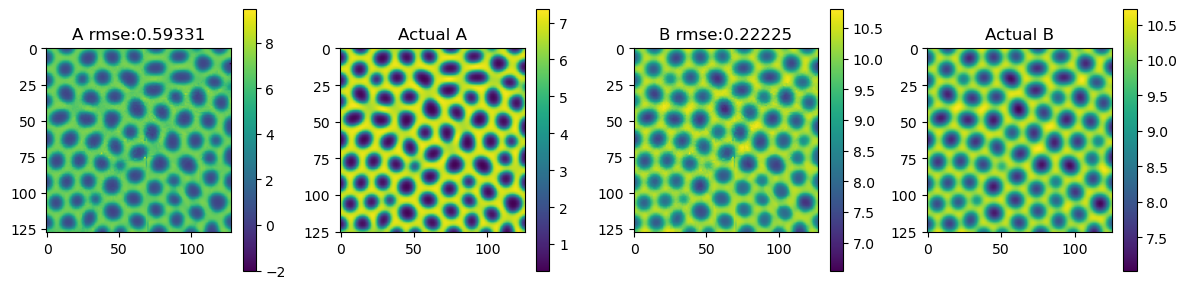

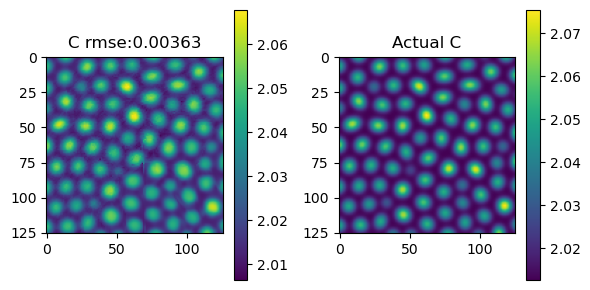

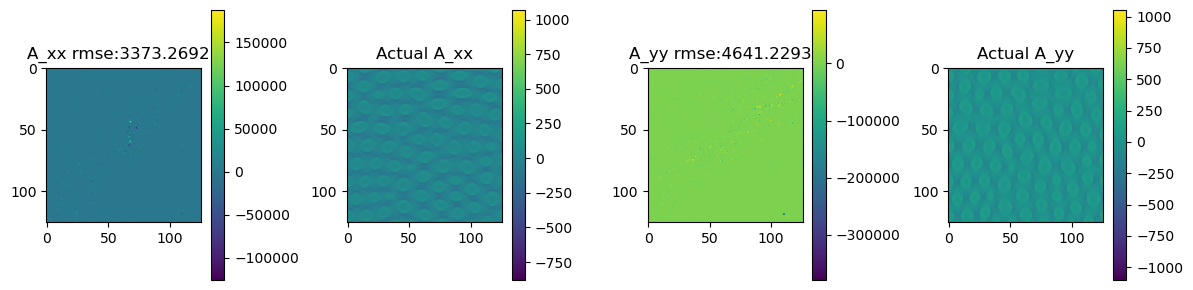

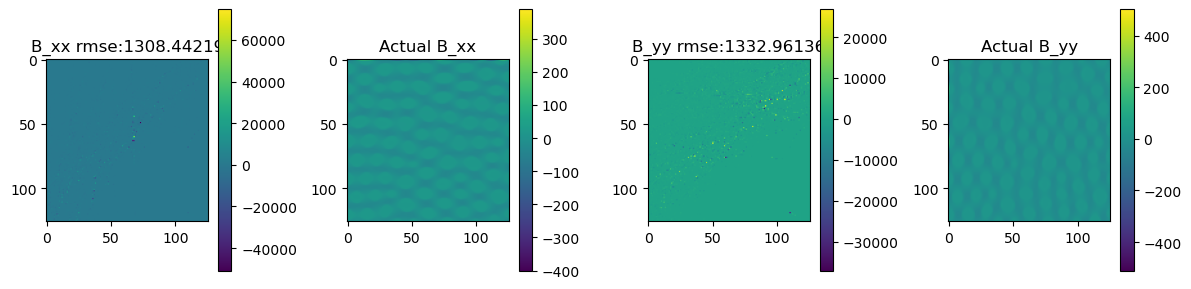

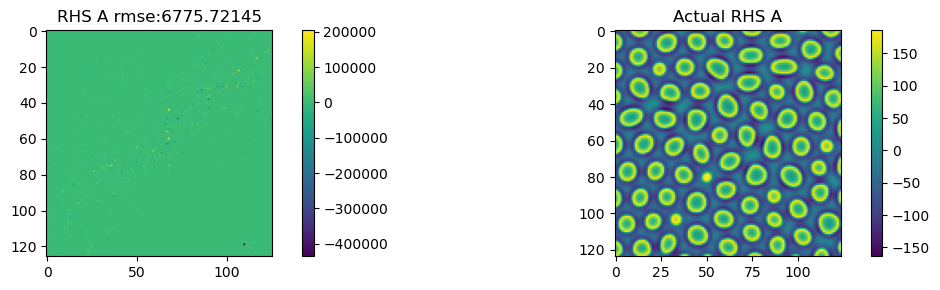

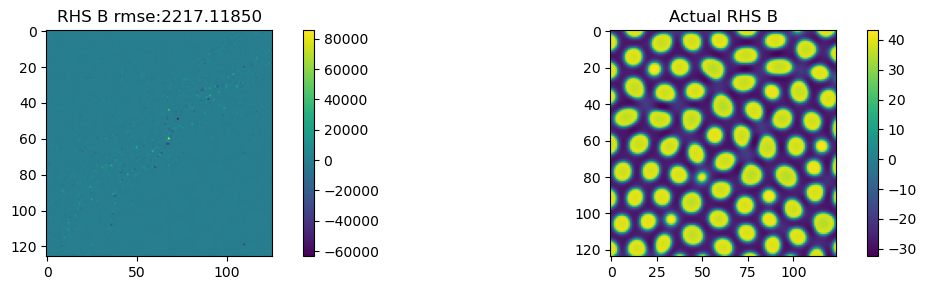

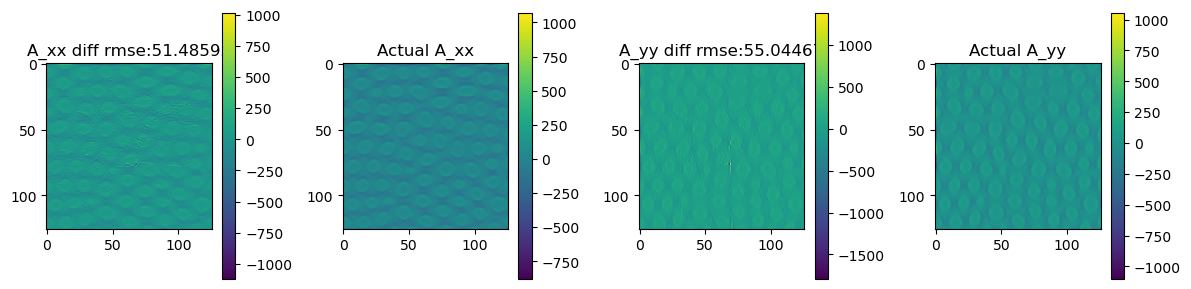

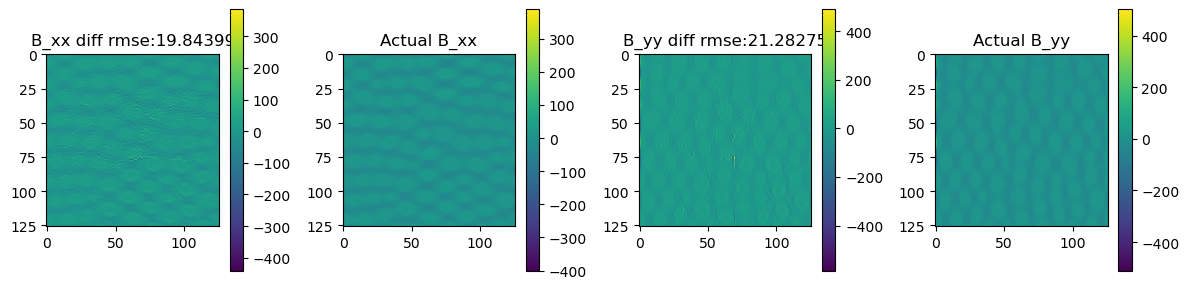

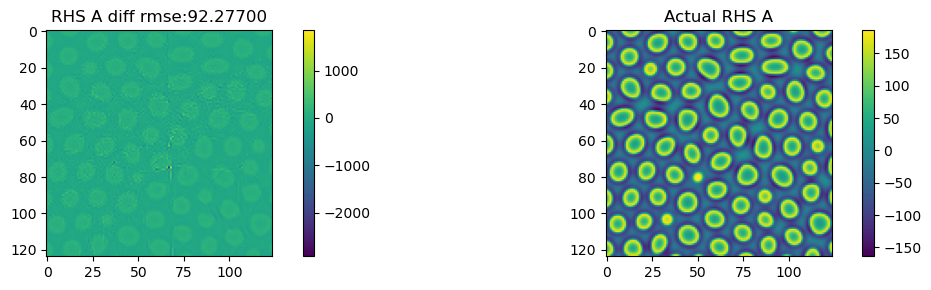

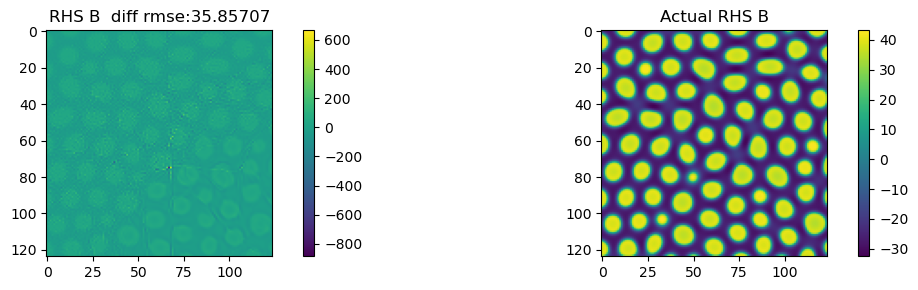

In [60]:
plot_state(pinn1, H_test,block_x=128,block_y=128)

In [61]:
def save_output(pinn, path):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    A = to(A)
    B = to(B)
    C = to(C)    
    
    data_out = np.stack([A, B, C])[..., np.newaxis]
    with open(f"{path}", "wb") as f:
        np.save(f, data_out)

In [62]:
save_output(pinn1, f"./index_{index}_noise_0.npy")